# IEEE Fraud Detection

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, roc_auc_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set_theme()

## 1 - Carregando os datasets

In [3]:
df_train_id = pd.read_csv("data/train_identity.csv")
df_train_tr = pd.read_csv("data/train_transaction.csv")
df_test_id = pd.read_csv("data/test_identity.csv")
df_test_tr = pd.read_csv("data/train_transaction.csv")

In [4]:
df_train_id.shape, df_train_tr.shape, df_test_id.shape, df_test_tr.shape

((144233, 41), (590540, 394), (141907, 41), (590540, 394))

In [45]:
df_train = pd.merge(df_train_tr, df_train_id, on='TransactionID', how='left')
df_test = pd.merge(df_test_tr, df_test_id, on='TransactionID', how='left')
df_test, df_val = train_test_split(df_test, test_size=0.2, random_state=42, stratify=df_test['isFraud'])

In [9]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(590540, 434)
(472432, 434)
(118108, 434)


In [10]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [11]:
df_test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
5307,2992307,0,174911,59.000,W,4988,334.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191582,3178582,0,4301977,23.378,C,3867,296.0,185.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260168,3247168,0,6229929,35.950,W,12577,268.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18516,3005516,0,497176,100.000,R,6019,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47538,3034538,0,1124702,75.000,H,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Variável alvo
target = df_train['isFraud'].value_counts()
target

0    569877
1     20663
Name: isFraud, dtype: int64

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


## 2 - Análise Exploratória

### Transaction Amount

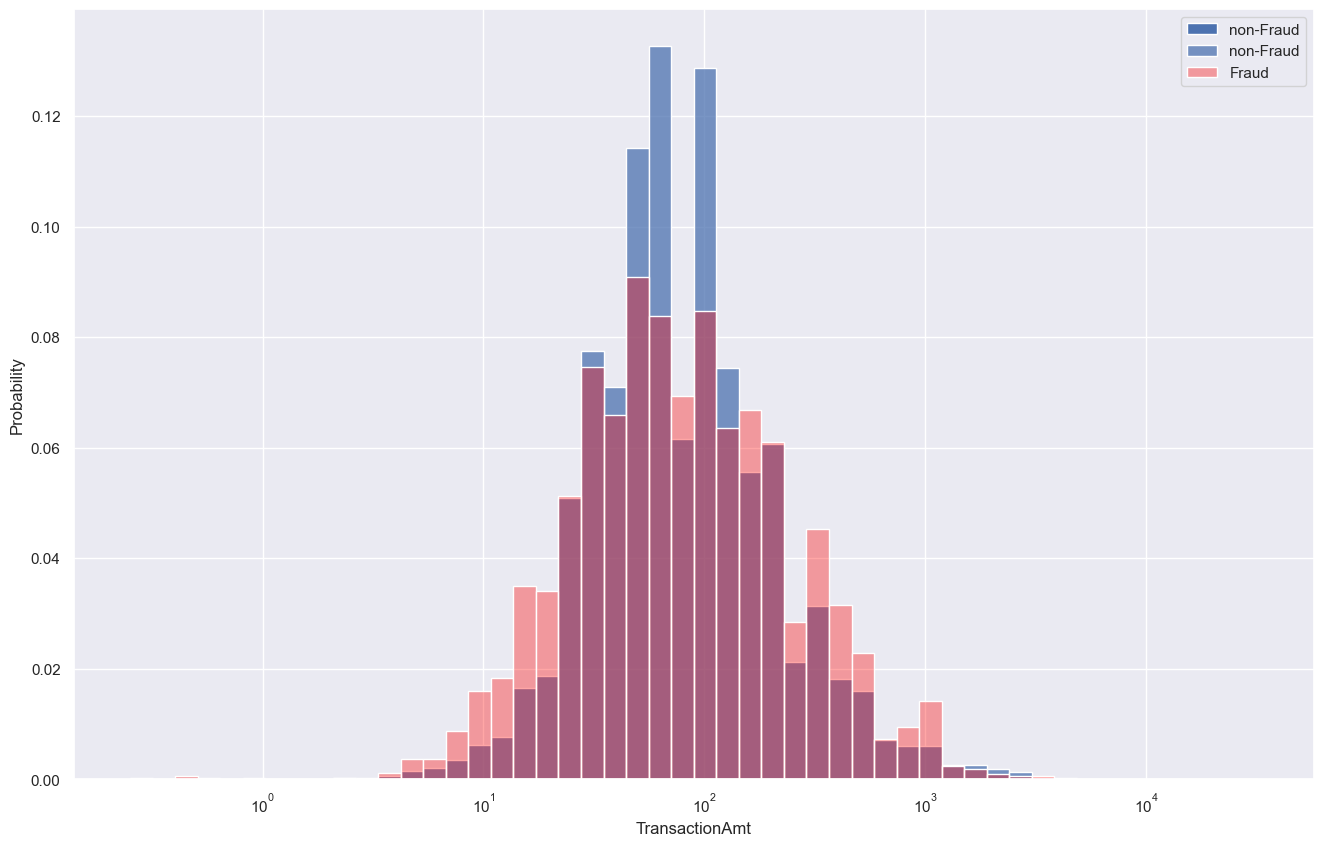

In [14]:
bins = np.histogram_bin_edges(np.log10(df_train['TransactionAmt']), bins=50)

plt.figure(figsize=(16,10))

# plt.subplot(121)
px = sns.histplot(data=df_train, x='TransactionAmt', label='non-Fraud',
                  bins=bins, stat='probability', log_scale=True)


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True], x='TransactionAmt', bins=bins,
                   stat='probability', log_scale=True, color='red', alpha=0.35, label='Fraud')


plt.legend()
plt.show()

### TransactionDT

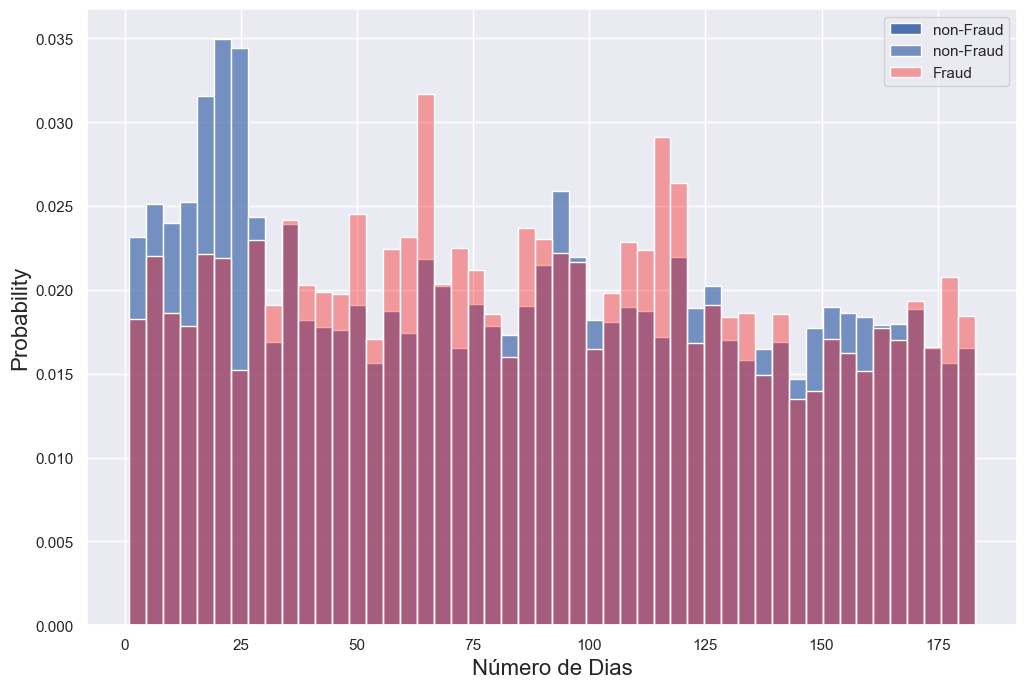

In [15]:
bins = np.histogram_bin_edges(df_train['TransactionDT'] / 86400, bins=50)

fig = plt.figure(figsize=(12,8))

# plt.subplot(121)
px = sns.histplot(data=df_train['TransactionDT'] / 86400, label='non-Fraud',
                  bins=bins, stat='probability')


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True]['TransactionDT'] / 86400, bins=bins,
                   stat='probability', color='red', alpha=0.35, label='Fraud')

px2.set_xlabel('Número de Dias', fontsize=16)
px2.set_ylabel('Probability', fontsize=16)
plt.legend()
plt.show()

In [16]:
#df_train[df_train.columns.difference(['TransactionID', 'TransactionDT', 'isFraud', 'TransactionAmt'])].hist(figsize=(20,348), layout=(87, 5), bins=30);

#### Avaliando o tipo de aparelho em que a transação foi realizada

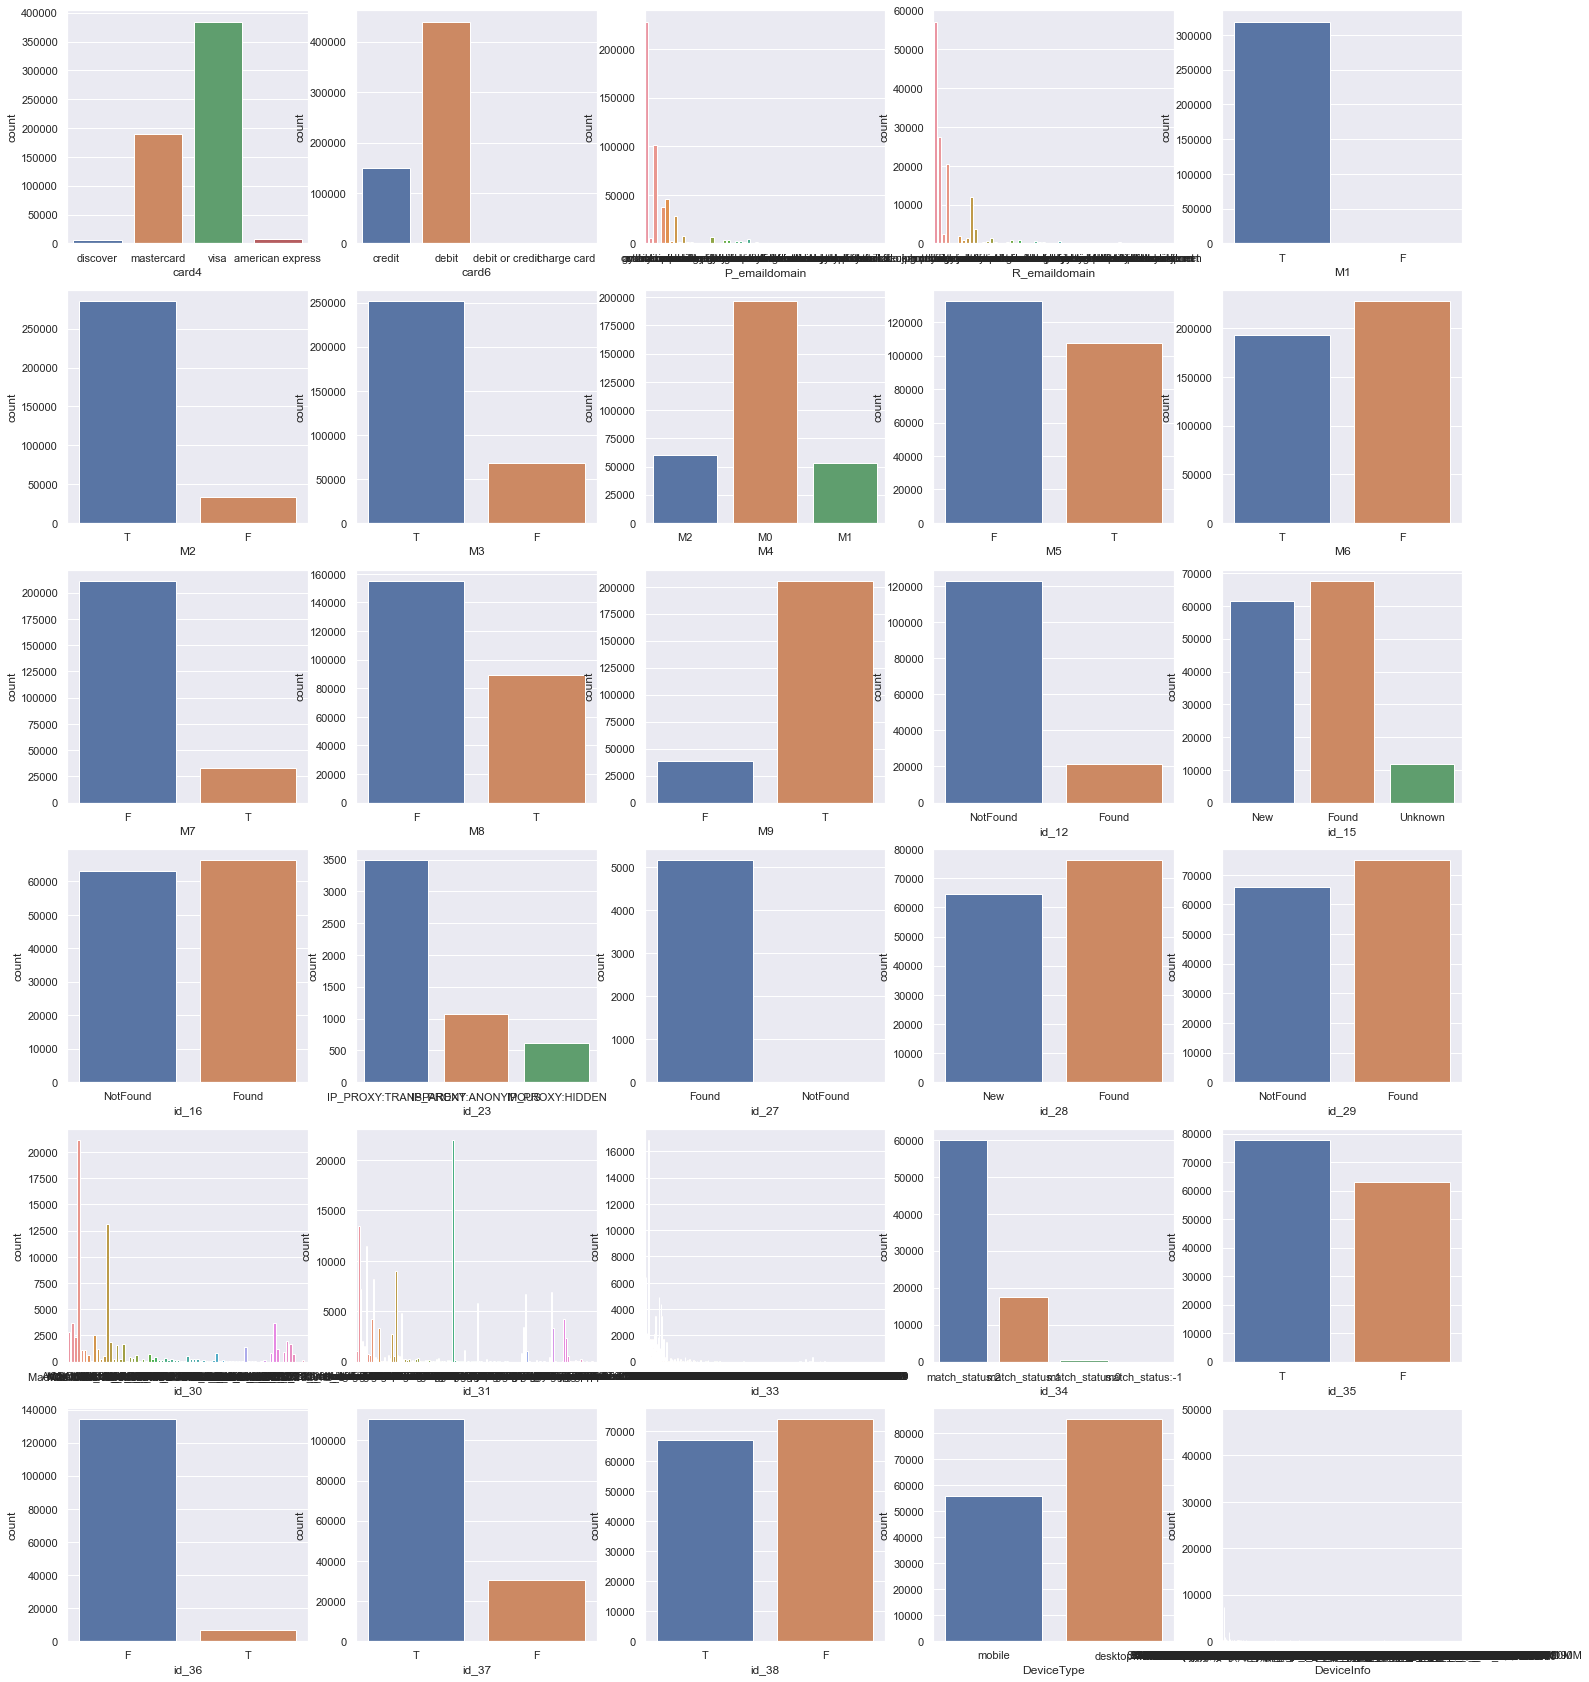

In [6]:
categorical_columns = df_train.select_dtypes(exclude=np.number).columns.to_list()

fig, axes = plt.subplots(6, 5, figsize=(25, 30))

aux = 1

for row in axes:
    for column in row:
        
        sns.countplot(data=df_train, x=categorical_columns[aux], ax=column)
        aux += 1


plt.show()

## Feature Engineering

### Fixing the problemns of 'id' columns with diff names

df_train -> ['id_01'] & df_val, df_test -> ['id-01']

In [46]:
df_train.columns == df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [19]:
len(df_train.columns) == len(df_test.columns)

True

In [47]:
columns_name = df_train.columns.to_list()

df_val.columns = columns_name
df_test.columns = columns_name

### P_emaildomain

In [48]:
df_train['P_emaildomain'].unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [49]:
# Reagrupando os domínios de e-mail (df_train)

def group_email_domain(pattern, email_domain, df):
    df['P_emaildomain'].replace(pattern, email_domain, regex=True, inplace=True)
    df['R_emaildomain'].replace(pattern, email_domain, regex=True, inplace=True)

gmail_match = re.compile(r'.*(gmail).*')

group_email_domain(gmail_match, 'gmail', df_train)
group_email_domain(gmail_match, 'gmail', df_test)
group_email_domain(gmail_match, 'gmail', df_val)

yahoo_match = re.compile(r'.*(yahoo).*')

group_email_domain(yahoo_match, 'yahoo', df_train)
group_email_domain(yahoo_match, 'yahoo', df_test)
group_email_domain(yahoo_match, 'yahoo', df_val)

microsoft_match = re.compile(r'.*(hotmail|outlook|live|msn).*')

group_email_domain(microsoft_match, 'microsoft', df_train)
group_email_domain(microsoft_match, 'microsoft', df_test)
group_email_domain(microsoft_match, 'microsoft', df_val)

others_match = re.compile(r'.*[^gmail|yahoo|microsoft].*')

group_email_domain(others_match, 'others', df_train)
group_email_domain(others_match, 'others', df_test)
group_email_domain(others_match, 'others', df_val)


In [23]:
df_test['R_emaildomain'].value_counts(normalize=True)

gmail        0.416086
microsoft    0.245128
others       0.238847
yahoo        0.099939
Name: R_emaildomain, dtype: float64

## Splitting data

In [50]:
def df_subset(df, size):
    df_sub = df.sample(frac=size, replace=False, random_state=42)

    return df_sub

df_train_05 = df_subset(df_train, 0.05)
df_train_10 = df_subset(df_train, 0.1)
df_train_20 = df_subset(df_train, 0.2)
df_train_50 = df_subset(df_train, 0.5)


for df in [df_train_05, df_train_10, df_train_20, df_train_50, df_train]:
    print(df.shape[0])

29527
59054
118108
295270
590540


In [26]:
def split_x_y(df):
    X = df.drop(['isFraud'], axis=1)
    y = df.loc[:, 'isFraud']
    
    return X, y

X_train_05, y_train_05 = split_x_y(df_train_05)
X_train_10, y_train_10 = split_x_y(df_train_10)
X_train_20, y_train_20 = split_x_y(df_train_20)
X_train_50, y_train_50 = split_x_y(df_train_50)
X_train, y_train = split_x_y(df_train)

X_val, y_val = split_x_y(df_val)

X_test, y_test = split_x_y(df_test)


In [51]:
encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_columns)
)

def train(X_train, y_train, X_val, y_val):

    pipe = make_pipeline(
        encode_categorical,
        DecisionTreeClassifier(min_samples_split=10, class_weight='balanced')
        )
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_val)
    
    # print(f"Val F1-Score: {f1_score(y_val, y_pred)}")
    print(f"Val ROC AUC score: {roc_auc_score(y_val, y_pred)}")
    # print(f"Val Precision Recall score: {precision_score(y_val, y_pred)}")

    return roc_auc_score(y_val, y_pred)

In [52]:
roc = []

for (x_train_, y_train_) in [
    (X_train_05, y_train_05),
    (X_train_10, y_train_10),
    (X_train_20, y_train_20),
    (X_train_50, y_train_50),
    (X_train, y_train)
]:
    print(f"Training with {x_train_.shape[0]} samples")
    roc.append(train(x_train_, y_train_, X_val, y_val))
    
    print()

Training with 29527 samples
Val ROC AUC score: 0.6443158497933495

Training with 59054 samples
Val ROC AUC score: 0.6885756194575072

Training with 118108 samples
Val ROC AUC score: 0.7186898712253426

Training with 295270 samples
Val ROC AUC score: 0.7279727476550371

Training with 590540 samples
Val ROC AUC score: 0.720956727608545



Text(0.5, 1.0, 'ROC AUC Score x Percentage of training data')

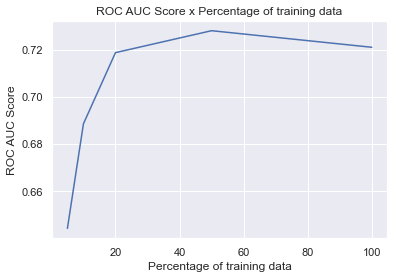

In [56]:
g = sns.lineplot(x=[5, 10, 20, 50, 100], y=roc);

g.set_xlabel('Percentage of training data')
g.set_ylabel('ROC AUC Score')
g.set_title('ROC AUC Score x Percentage of training data')

In [37]:
roc

[None, None, None, None, None]